# SpectralDefocusCam Iterative Reconstruction Demo

In [1]:
import matplotlib.pyplot as plt
import scipy.io
import utils.helper_functions as helper
import utils.diffuser_utils as diffuser_utils
import utils.psf_utils as psf_utils
import train
import PIL.Image as Image
import numpy, torch
import os, tqdm
import glob

# Change this to GPU or CPU depending on your machine 
device = "cuda:0"

%load_ext autoreload
%autoreload 2

In [2]:
if "cuda" in device:
    import cupy as np
    print(torch.cuda.get_device_name(device))
else:
    import numpy as np


NVIDIA GeForce RTX 3090


### View calibration data and image

In [3]:
# defocuscamdata_path = "/home/cfoley_waller/defocam/defocuscamdata"
# calib_mat_path_rel = "/home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/calib_matrix_full_10_18_2023_NEW_exp25.64ms_gain14.9_navg16_378-890/calibration_matrix.mat"
# psf_path_rel = "/home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/10_26/singlepos/psfs_ONAXIS_telecent25um_10_26"
# data_path_rel = "sample_data"
# test_meas_path_rel = "/home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/10_26/measurements/exp_meas_ducksmallside_ONAXIS_telecent25um_10_26"

In [3]:
psf_path_rel = "/home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/11_21/singlepos/psfs_ONAXIS_telecent25um"
test_meas_path_rel = "/home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/11_21/exp_meas/duckincar"
calib_mat_path_rel = "/home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/calib_matrix_11_10_2023_2_preprocessed/calibration_matrix_450-810_30chan_stride12_avg12.mat"

#exp params
sim_blur = True
w_init = [0.003, 0.018, 0.04, 0.06, 0.095]
crop_center = [1000, 2000]
crop_size = [768, 768]
patch_size = [768, 768]
ksizes = [7, 21, 45, 55, 65]
exposures = [1 / 662, 1 / 110, 1 / 45, 1 / 30, 1 / 21]
num_ims = len(exposures)

# calibration matrix
mask = diffuser_utils.load_mask(calib_mat_path_rel, crop_center, crop_size, patch_size)

# psfs (for visualization)
psf_stack = psf_utils.get_lsi_psfs(
    psf_path_rel, 
    blur_levels=num_ims,
    crop_size=crop_size[0], 
    dim=patch_size[0],
    ksizes=ksizes,
    use_first=True,
    exposures=exposures, 
    threshold=0.55,
    zero_outside=128,
    blurstride=1
)

Reading psf: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Scaled psfs by values: [1.0, 0.1661631419939577, 0.06797583081570997, 0.045317220543806644, 0.03172205438066465]


Drawing plot: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


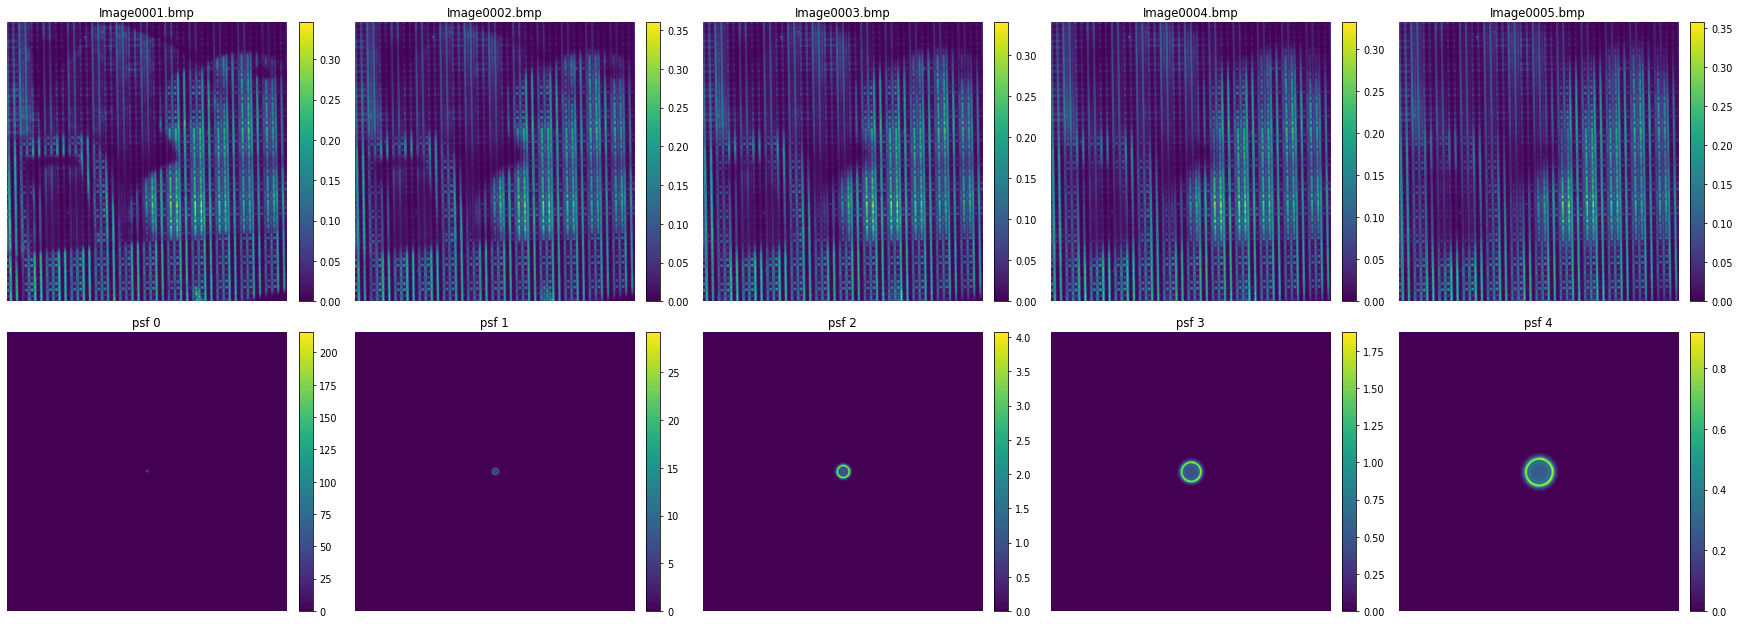

In [4]:
# Experimental measurements
files = sorted(glob.glob(os.path.join(test_meas_path_rel, "*.bmp")))
prep = lambda x: diffuser_utils.preprocess_meas(
    x, 
    center=crop_center,
    crop_size=crop_size[0],
    dim=patch_size[0],
    outlier_std_threshold=3
)
measurements = [prep(numpy.array(Image.open(x))) for x in tqdm.tqdm(files, "Preprocessing")]

fig, ax = plt.subplots(2, len(measurements), figsize=(5*len(measurements), 9), dpi=70)
for i, meas in tqdm.tqdm(list(enumerate(measurements)), "Drawing plot"):
    img1 = ax[0][i].imshow(meas)
    fig.colorbar(img1, ax=ax[0][i], fraction=0.046, pad=0.04)
    img2 = ax[1][i].imshow(psf_stack[i])
    fig.colorbar(img2, ax=ax[1][i], fraction=0.046, pad=0.04)
    ax[0][i].axis('off')
    ax[1][i].axis('off')
    ax[0][i].set_title(os.path.basename(files[i]))
    ax[1][i].set_title(f"psf {i}")

plt.tight_layout()

We can also simualte the psf as a gaussian blur, if we don't trust the psf measurements.

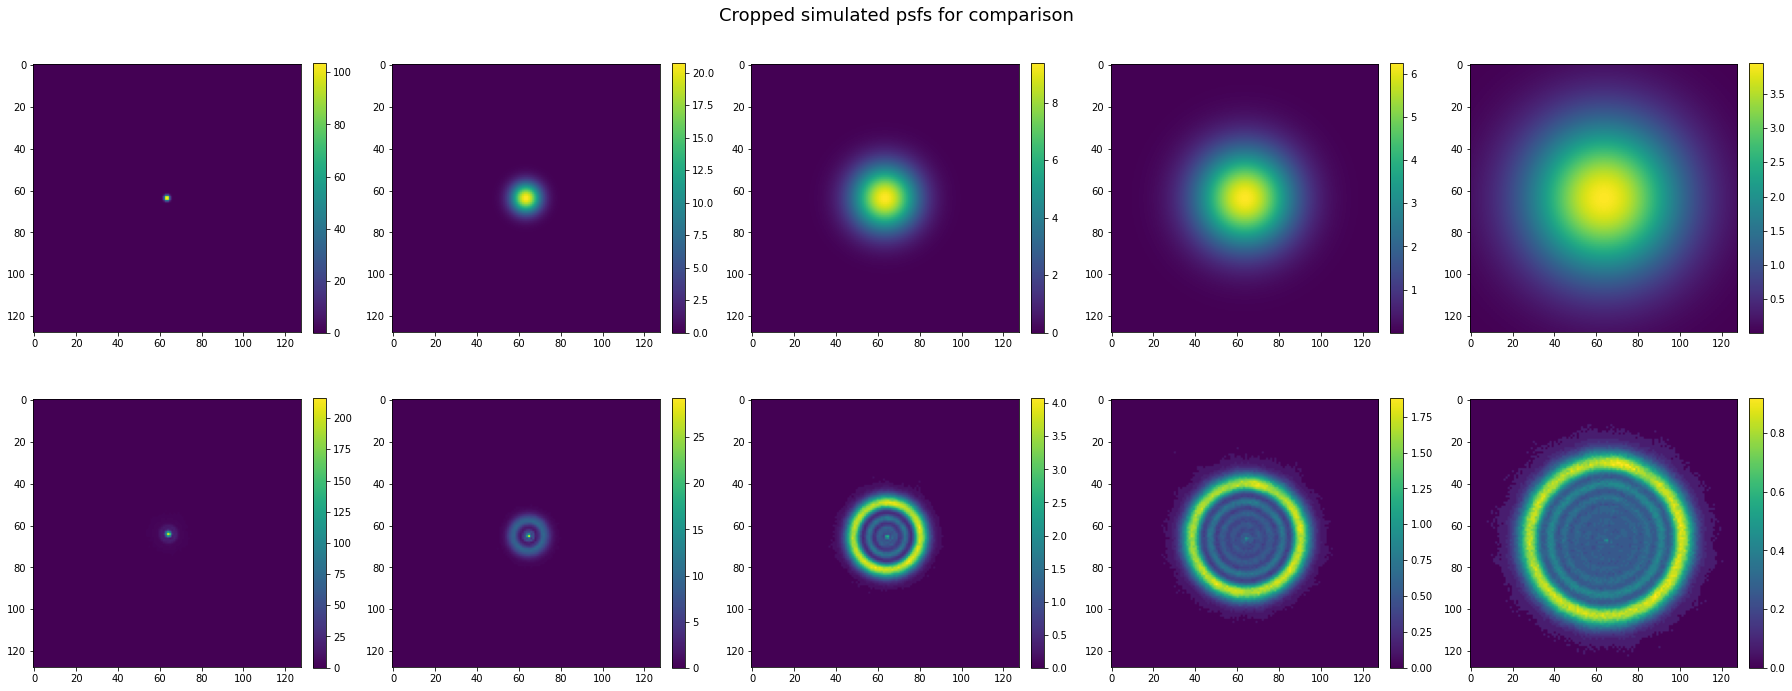

In [6]:
w_init = torch.tensor([0.003, 0.018, 0.04, 0.06, 0.095])
sim_psfs = psf_utils.simulate_gaussian_psf(patch_size[0], w_init)

for i in range(sim_psfs.shape[0]):
    sim_psfs[i] = sim_psfs[i] * 255

#scale psfs
if sim_blur:
    fig, ax = plt.subplots(2,sim_psfs.shape[0], figsize = (sim_psfs.shape[0]*5, 10))
    for i in range(sim_psfs.shape[0]):
        im1 = ax[0,i].imshow(sim_psfs[i][256+64:512-64,256+64:512-64])
        fig.colorbar(im1, ax=ax[0,i], fraction=0.046, pad=0.04)
        im2 = ax[1,i].imshow(psf_stack[i][256+64:512-64,256+64:512-64])
        fig.colorbar(im2, ax=ax[1,i], fraction=0.046, pad=0.04)
    plt.suptitle("Cropped simulated psfs for comparison", fontsize=18)
    plt.tight_layout()
    plt.show()

In [7]:
helper.plot_cube_interactive(mask)

FigureWidget({
    'data': [{'type': 'image',
              'uid': '53cc7b05-d5d8-4140-a42f-39c6f5fbe558',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[ 4,  3,  1],
                           [ 7,  7,  4],
                           [15, 14,  5],
                           ..., 
                           [ 5,  7,  6],
                           [ 3,  5,  5],
                           [ 4,  4,  4]],
                   
                          [[ 3,  3,  3],
                           [ 7,  7,  4],
                           [13, 14,  5],
                           ..., 
                           [ 5,  7,  6],
                           [ 4,  6,  5],
                           [ 4,  5,  4]],
                   
                          [[ 5,  4,  3],
                           [ 6,  6,  4],
                           [10, 10,  5],
                           ..., 
                           [ 5,  7,  7],
                           [ 5,  6,  5],

### Initialize forward model

In [7]:
stack_depth = 5 # number of images in your stack
blurstride = 1 # stride between ordered blur levels of your measurements

config = {
    "device": device,
    "mask_dir": calib_mat_path_rel,
    "psf_dir": psf_path_rel,
    "data_precomputed": False,
    "forward_model_params": {
        "stack_depth": stack_depth,
        "psf": {
            "lri": False,
            "stride": blurstride,
            "symmetric": True,
            "optimize": False,
            "padded_shape": crop_size[0],
            "exposures": exposures,
            "w_init": w_init,
        },
        "operations": {
            "sim_blur": False,
            "sim_meas": False,
            "adjoint": False,
            "spectral_pad": False,
            "roll": False
        }
    },
    "recon_model_params": {
        "model_name": "fista",
        "iters": 300,
        "prox_method": 'tv',
        "tau": 0.5,
        "tv_lambda": 1.3,
        "tv_lambdaw": 5,
        "tv_lambdax": 13,
        "lowrank_lambda": 0.4,
        "print_every": 1
    },
    "batch_size": 1,
    "patch_size": patch_size,
    "patch_crop": crop_size,
    "image_center": crop_center,
    "loss_function": {
        "name": "mse",
        "params": {
        }
    }
}

sel_meas_stack = torch.tensor(numpy.stack(measurements, axis=0))[:stack_depth*blurstride:blurstride]
model = train.get_model(config, device=device)#, force_psfs=np.array(sim_psfs))
print(sel_meas_stack.shape)


Reading psf: 100%|██████████| 5/5 [00:00<00:00, 32.14it/s]


Scaled psfs by values: [1.0, 0.1661631419939577, 0.06797583081570997, 0.045317220543806644, 0.03172205438066465]
device =  None , using GPU and cupy
<class 'cupy.core.core.ndarray'> <class 'cupy.core.core.ndarray'>
torch.Size([5, 768, 768])


## Run model with fista recon

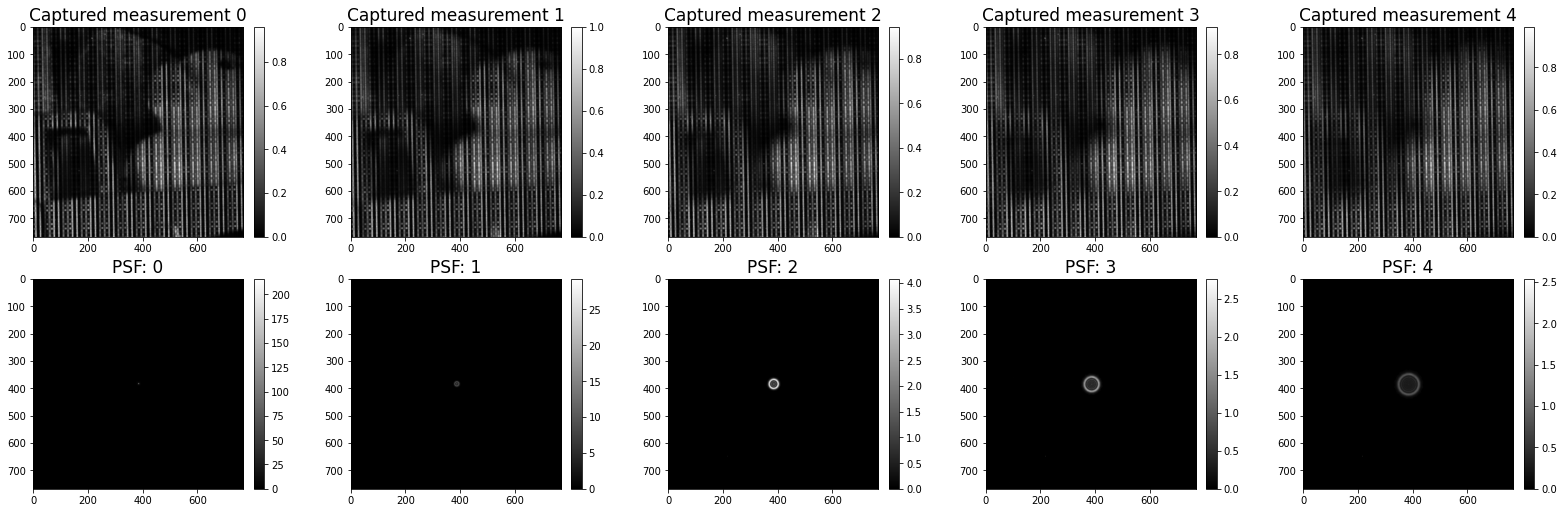

In [9]:
# Let's look at the measurement images and psfs
meas_stack = model.model1(sel_meas_stack.unsqueeze(0).to(device))[0,...]

psfs = model.model2.psfs.get()
num_cols = config["forward_model_params"]["stack_depth"]
fig, ax = plt.subplots(2, num_cols, figsize=(num_cols * 5.5, 8.5))

for i, im in enumerate(meas_stack):
    img1 = ax[0][i].imshow(im.cpu().numpy(), cmap = "gray")
    fig.colorbar(img1, ax=ax[0][i], fraction=0.046, pad=0.04)
    img2 = ax[1][i].imshow(psfs[i], cmap = "gray")
    fig.colorbar(img2, ax=ax[1][i], fraction=0.046, pad=0.04)
    ax[0][i].set_title(f"Captured measurement {i}", fontsize=17)
    ax[1][i].set_title(f"PSF: {i}", fontsize=17)
    
plt.show()

In [8]:
model.model2.iters = 12
model.model2.tv_lambda = 0.08
model.model2.tv_lambdax = 0.07
model.model2.tv_lambdaw = 0.08

iteration:  0  loss:  28917.448223671207


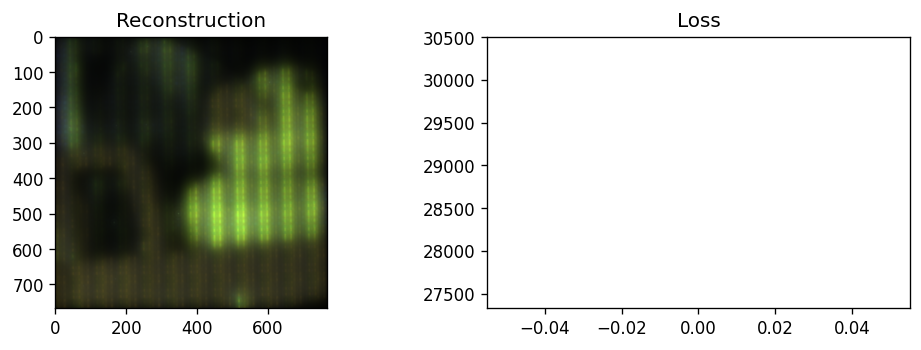

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  1  loss:  15961.550617383193


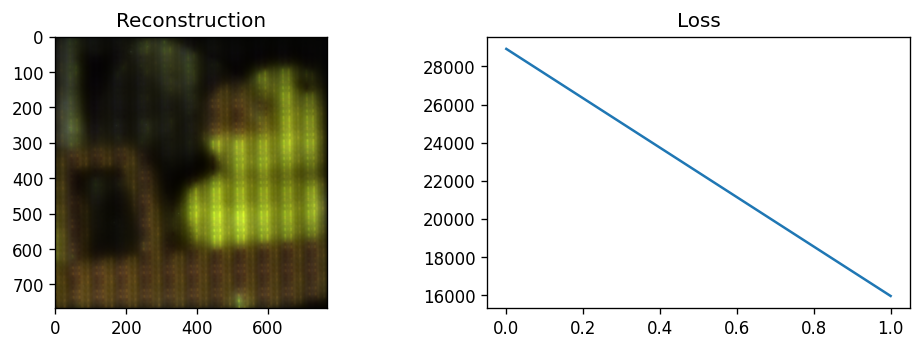

iteration:  2  loss:  11457.85506617732


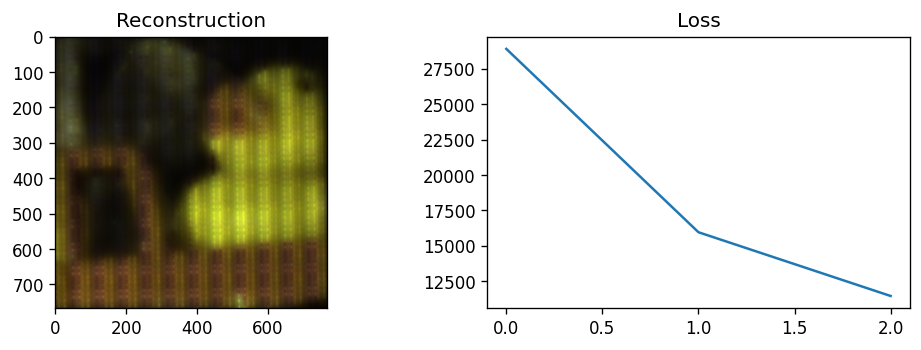

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  3  loss:  8309.279508397243


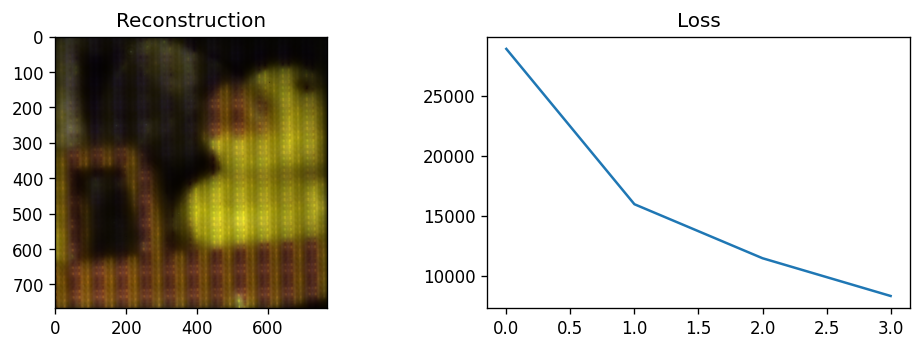

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  4  loss:  6013.000972673328


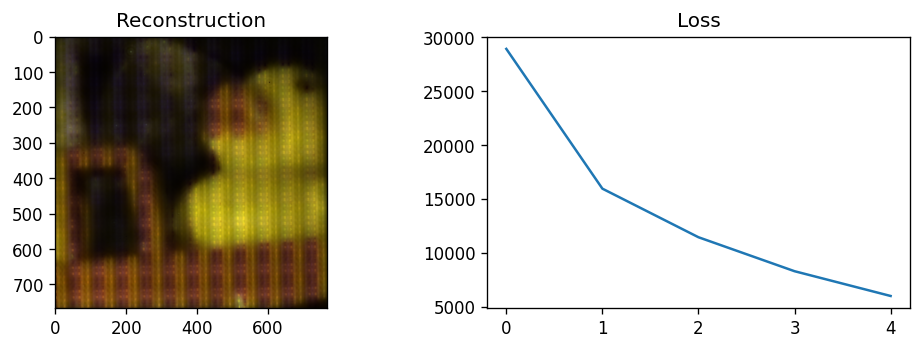

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  5  loss:  4620.438918889163


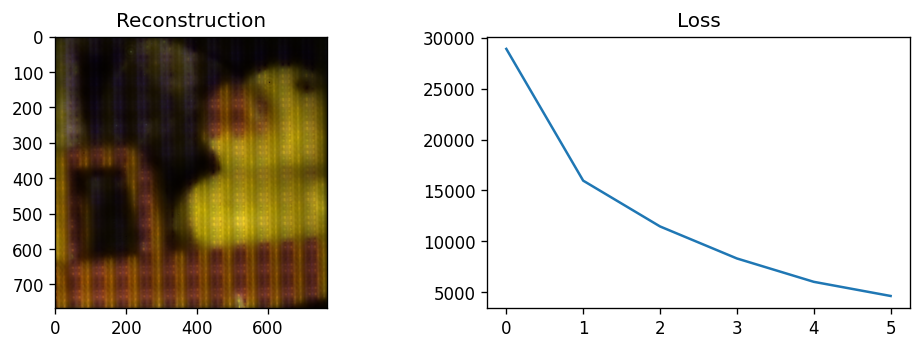

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  6  loss:  3610.0063782003535


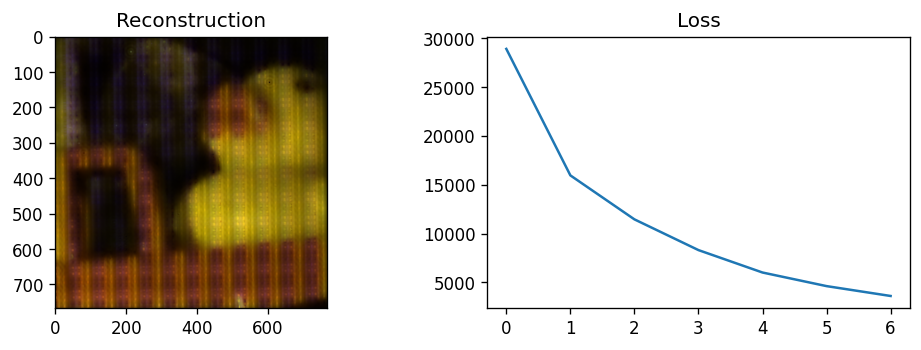

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  7  loss:  3031.684866974072


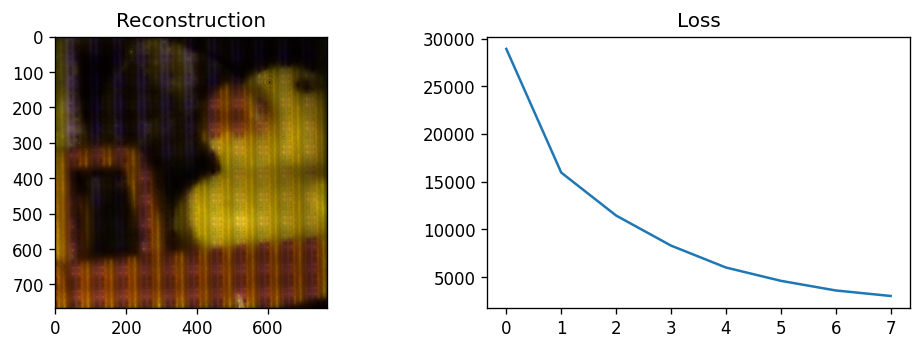

iteration:  8  loss:  2597.055833430165


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


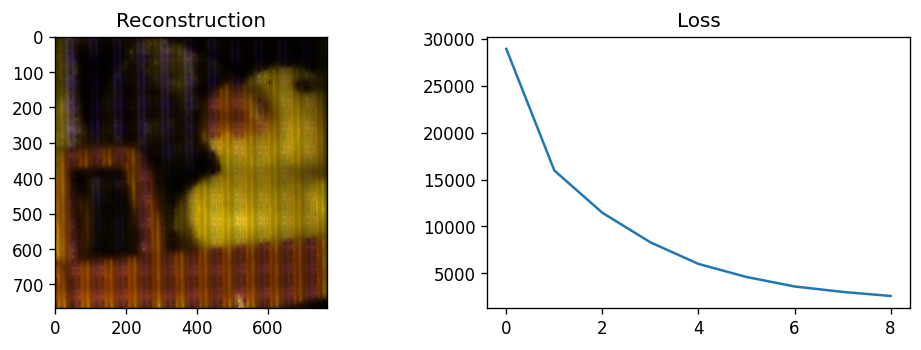

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  9  loss:  2322.3879033975563


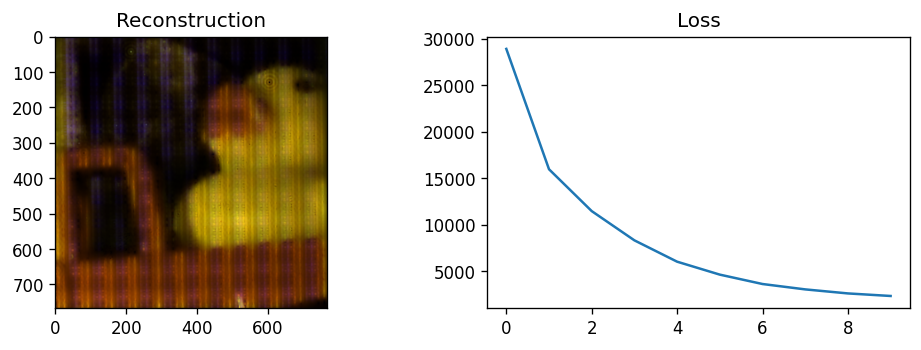

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  10  loss:  2096.7664941919775


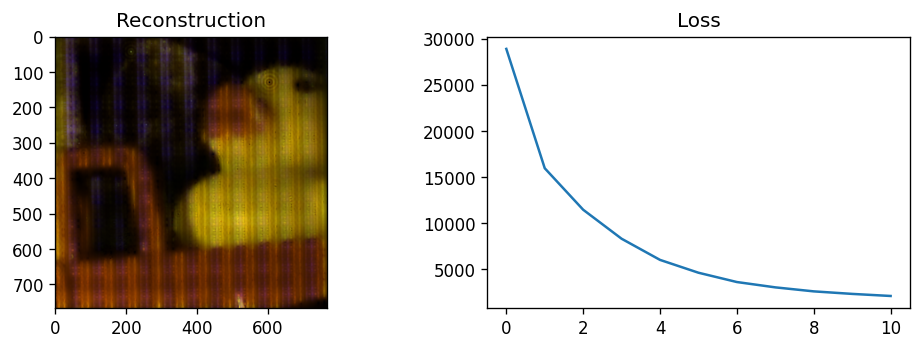

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  11  loss:  1927.2853594749745


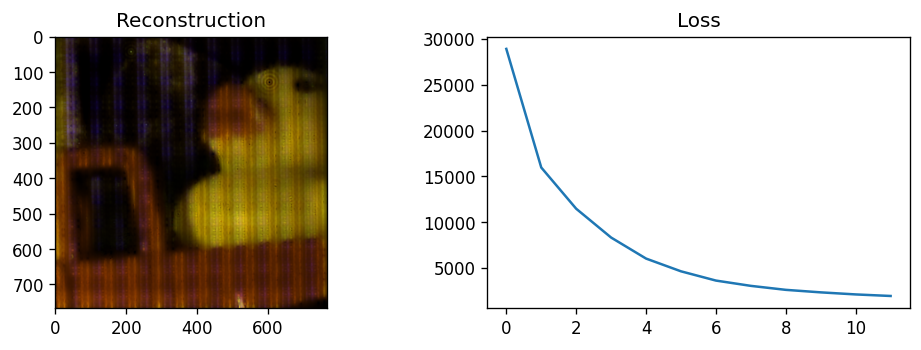

In [9]:
measurement = sel_meas_stack.unsqueeze(0).to(device)
out = model(measurement)

### Visualize Outputs

In [10]:
recon = model.model2.out_img

In [13]:
# Visualize in 3D scan
helper.plt3D(helper.pre_plot(recon, False), title="Spectral Reconstruction")

interactive(children=(IntSlider(value=1, description='r', max=29), Output()), _dom_classes=('widget-interact',…

In [11]:
# Visualize spectra
helper.plot_cube_interactive(recon)

FigureWidget({
    'data': [{'type': 'image',
              'uid': '0a2ee3bb-0c1b-4bbc-b21e-a1c1e7e35d15',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[ 47,  45,  17],
                           [ 49,  47,  17],
                           [ 48,  46,  16],
                           ..., 
                           [ 27,  30,  23],
                           [ 26,  29,  23],
                           [ 25,  27,  21]],
                   
                          [[ 51,  50,  18],
                           [ 54,  52,  18],
                           [ 52,  50,  16],
                           ..., 
                           [ 29,  32,  26],
                           [ 29,  32,  26],
                           [ 26,  29,  23]],
                   
                          [[ 54,  52,  18],
                           [ 57,  54,  18],
                           [ 55,  53,  17],
                           ..., 
                           [ 29,  32

In [13]:
recon.shape

(768, 768, 30)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


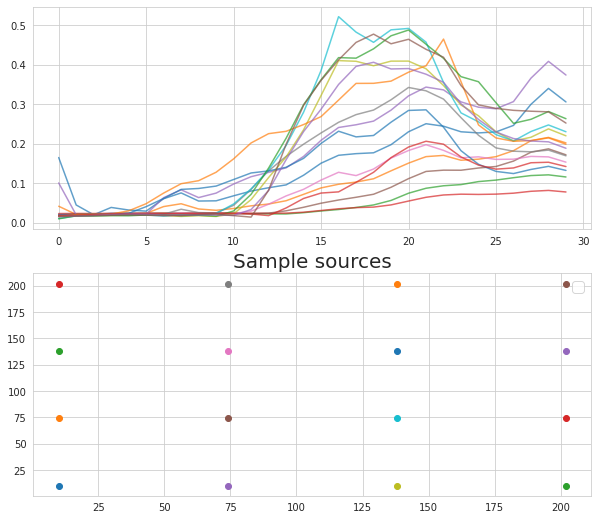

In [27]:
import seaborn
seaborn.set_style("whitegrid")

recon_norm = (recon - np.min(recon)) / np.max(recon - np.min(recon))
fig, ax = plt.subplots(2,1, figsize=(10,9))
for i in range(30, recon.shape[0], recon.shape[0]//4):
    for j in range(30, recon.shape[1], recon.shape[1]//4):
        ax[0].plot(recon_norm[i,j], alpha=0.7)
        ax[1].scatter(i//3,j//3)

ax[1].set_title("Sample sources", fontsize=20)
plt.legend(fontsize=15, loc="upper right")
plt.show()